In [1]:
import pandas as pd
import seaborn as sbs
import numpy as np
import json

import os

from util_scraper import *

In [2]:
title = 'car_title'

# file_path = os.path.abspath(__file__)
file_path = os.path.dirname(os.path.realpath("__file__"))+"/data_cleaner.py"

cats_path = f'data/{sns.car_name}_cats_to_labels.json'
cleaned_path = f'data/{sns.car_name}_clean.csv'
nonoutlier_path = f'data/{sns.car_name}_no.csv'

norm_path = f'data/{sns.car_name}_cats_to_norm.json'


trim_indices = (3,-2)


#### FEATURES ####
cols = ['car_title', 'car_year', 'price','mileage','transmission','ext_color','int_color','drivetrain','title','accident','owners','certified',
        'SP','LS','AW','CP','HS','AS','BC','S/M','SCP','BHE','BXH','PP','MP','SP','CP']
cat_cols = ['body_type', 'transmission', 'ext_color', 'int_color', 'drivetrain', 'trim', 'title', 'owners', 'accident']



In [3]:
### COMPILE DATA ###
####################

def concat_path(_file):
    return f'data_{sns.car_name}/{_file}'
files =  list( map(concat_path, os.listdir('/'.join(file_path.split('/')[:-1])+f'/data_{sns.car_name}')) )


df = pd.concat(
    map(pd.read_csv, files)
)

In [4]:
print(df.shape)

(2809, 25)


In [5]:
### ADJUST FEATURES ###
#######################

df['trim'] = df['car_title'].apply(lambda x: ' '.join( x.split(' ')[trim_indices[0]:trim_indices[1]] ))
df['car_year'] = df['car_title'].apply(lambda x: int(x.split(' ')[0]) )

df['car_year'] = p_911_year_to_gen(df['car_year'].to_numpy())

df['accident'] = df['accident'].apply(lambda x: '1' if x=='one' else x)


In [6]:
if sns.car_name == "porsche_911":
    df = df[df['price'] <= 250000]
    df['price'] = df['price'].apply(lambda x: int(x))
    
    df['body_type'] = df['car_title'].apply(lambda x: map_body_type(x))
    df['transmission'] = df['transmission'].apply(lambda x: map_transmission(x))



In [7]:

# df = df[df.groupby('trim').trim.transform('count') >= 25]
# df = df[df.groupby('owners').owners.transform('count') >= 25]
# df = df[df.groupby('car_year').car_year.transform('count') >= 25]
# df = df[df.groupby('accident').accident.transform('count') >= 25]
# print(df.head())

In [8]:
print(df.shape)

(2593, 28)


In [9]:
### FEATURE -> CATEGORICAL ###
##############################

df_cat_cols = df[cat_cols].apply(lambda x: pd.factorize(x, sort=True)[0])

cats_to_labels = {}
for (feature,ser),(_,ser2) in zip(df[cat_cols].iteritems(), df_cat_cols.iteritems()):
    cat_to_label = {}
    for (_,val),(_,val2) in zip(ser.iteritems(), ser2.iteritems()):
        cat_to_label[val2] = val
    cats_to_labels[feature] = cat_to_label
df[cat_cols] = df_cat_cols

with open(cats_path, 'w') as fw:
    json.dump(cats_to_labels, fw)


print(f'Length of DataFrame is: {df.shape[0]}, with {df.shape[1]} features')

df.to_csv(cleaned_path, index=False, encoding="UTF-8")


Length of DataFrame is: 2593, with 28 features


In [10]:
### DELETE USELESS FEATURES ###
###############################

del df[title]
del df['ext_color']
del df['int_color']
del df['accident']
del df['title']

del df['body_type']
# del df['drivetrain']


In [11]:
### REMOVE OUTLIERS ###

non_outlier_indices = remove_df_outliers(df)
df_non_outlier = df[non_outlier_indices.all(1)]


# ### REMOVE OTHER BODY TYPES ###
# df_non_outlier = df_non_outlier[df_non_outlier.body_type != 2]

# ### REMOVE OTHER TRANSMISSIONS ###
# df_non_outlier = df_non_outlier[df_non_outlier.transmission <= 5]

In [12]:
norm_cols = ['car_year', 'mileage', 'owners', 'price', 'trim', 'transmission', 'drivetrain']


col_to_norm = {}
for col in df.columns:
    col_to_norm[col] = df_non_outlier[col].max()

with open(norm_path, 'w') as fw:
    json.dump(col_to_norm, fw)

cols_max = df_non_outlier[df_non_outlier.columns].max()
for col, _max in cols_max.iteritems():
    if _max == 0:
        del df_non_outlier[col]
del df_non_outlier['AW']
del df_non_outlier['LS']

df_non_outlier = df_non_outlier[df_non_outlier.columns] /df_non_outlier[df_non_outlier.columns].max()


In [13]:
print(df_non_outlier.shape)

(2240, 17)


<Figure size 432x288 with 0 Axes>

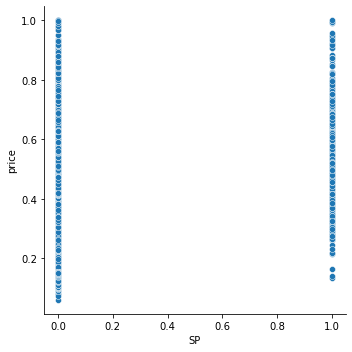

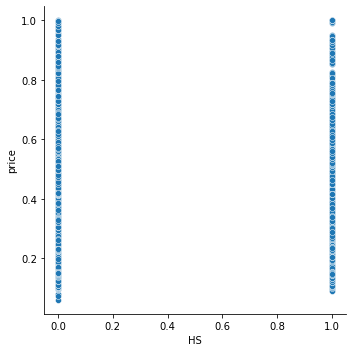

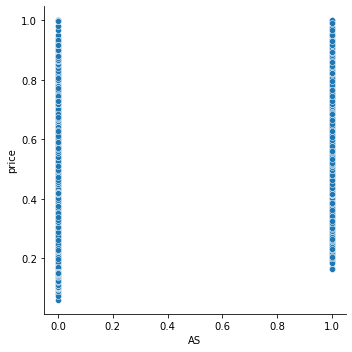

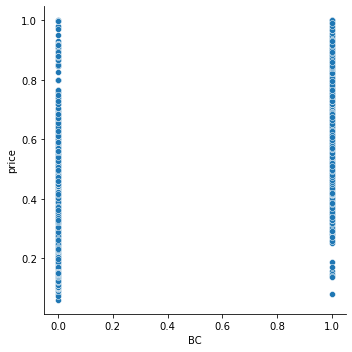

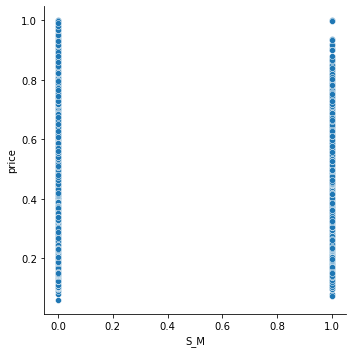

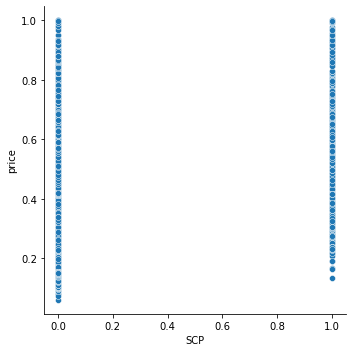

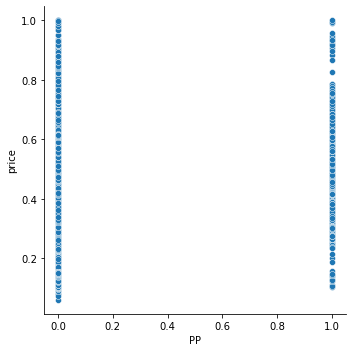

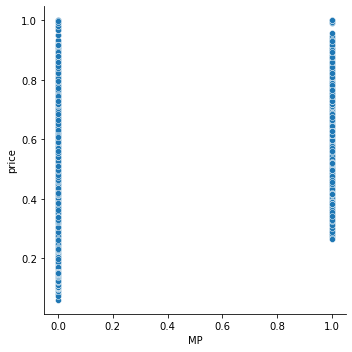

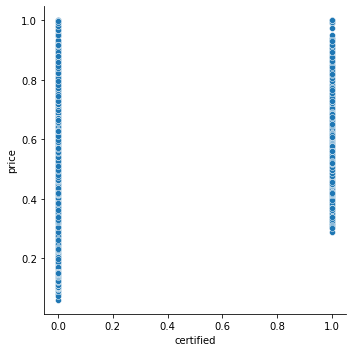

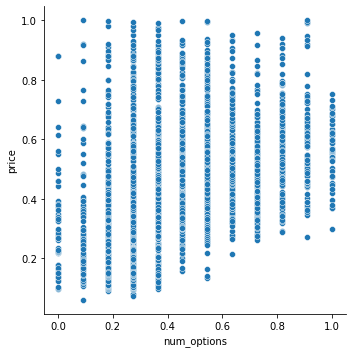

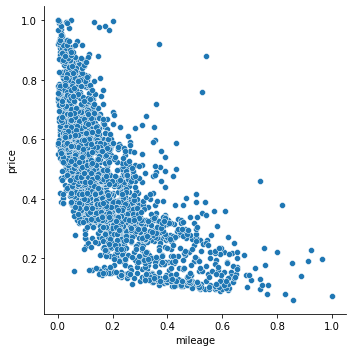

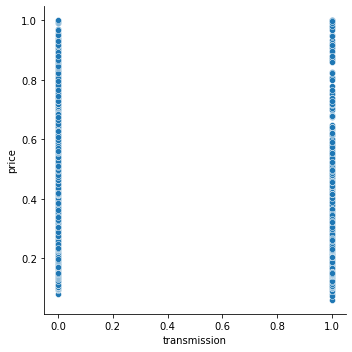

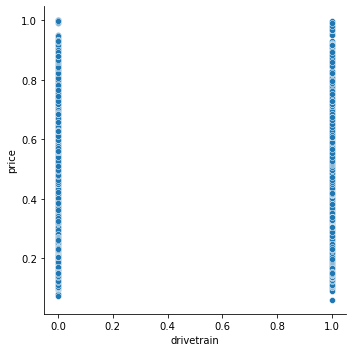

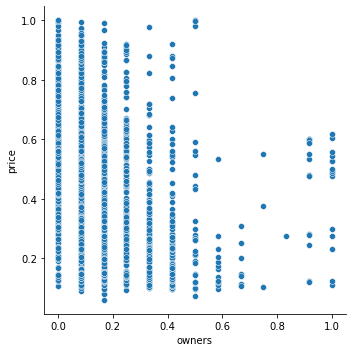

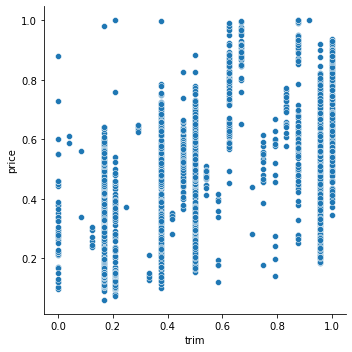

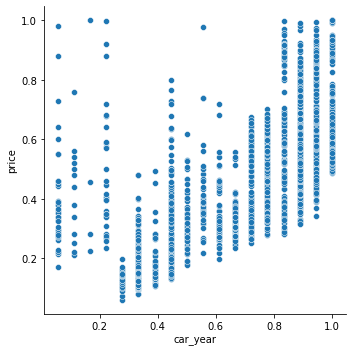

In [14]:
### COLUMN DISTRIBUTIONS ###

for column in df_non_outlier.columns:
    fig = sbs.histplot(df_non_outlier[column]).get_figure()
    fig.savefig(f'_data_model/hist_{column}.jpg', bbox_inches='tight')
    fig.clf()

for column in df_non_outlier.columns:
    if column == 'price': continue
    fig = sbs.relplot(x=df_non_outlier[column], y=df_non_outlier['price'])
    fig.savefig(f'_data_model/rel_price_{column}.jpg', bbox_inches='tight')
    # fig.clf()

SP              0.193063
HS              0.045879
AS              0.310857
BC              0.548493
S_M            -0.107858
SCP             0.189726
PP              0.070736
MP              0.329480
certified       0.264735
num_options     0.349861
price           1.000000
mileage        -0.699208
transmission   -0.253965
drivetrain     -0.150130
owners         -0.339816
trim            0.509398
car_year        0.658521
Name: price, dtype: float64


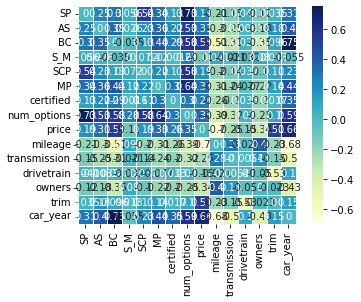

In [15]:
### CORRELATION MATRIX ###

corrs = df_non_outlier.corr()

print(corrs['price'])
for col in df_non_outlier.columns:
    if abs(corrs['price'][col]) < 0.1:
        del df_non_outlier[col]

corrs = df_non_outlier.corr()
np.fill_diagonal(corrs.values, 0)

# corr_plot = sbs.heatmap(corrs, cmap="YlGnBu", annot=True, linewidths=.5)
corr_plot = sbs.heatmap(corrs, cmap="YlGnBu", annot=True, linewidths=.5, square=True)
corr_plot.get_figure().savefig(f'_data_model/corr_heatmap.jpg', bbox_inches='tight')

In [16]:
df_non_outlier.to_csv(nonoutlier_path, index=False, encoding="UTF-8")